# Previsão de renda

## Etapa 1 CRISP - DM: Entendimento do negócio

Estimar a renda dos novos clientes de uma instituição financeira, usando variáveis disponíveis no banco de dados, sem exigir documentos comprobatórios. 

## Etapa 2 Crisp-DM: Entendimento dos dados

### Dicionário de dados

| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data referencia                                       | object|
| id_cliente              |  Codigo identificador                                       | INT|
| sexo                    |  sexo cliente                                       | object boleano|
| posse_de_veiculo        |  cliente tem veiculo?                                       | object boleano|
| posse_de_imovel         |  cliente tem imovel?                                       | object boleano|
| qtd_filhos              |  quantidade filhos                                       | INT|
| tipo_renda              |  De onde vem a renda do cliente                                       | object|
| educacao                |  escolaridade cliente                                       | object|
| estado_civil            |  esdado civil                                        | object|
| tipo_residencia         |  tipo residencia                                       | object|
| idade                   |  idade cliente                                       | INT|
| tempo_emprego           |  tempo na empresa atual                                       | float|
| qt_pessoas_residencia   |  quantidade de pessoas na residencia                                       | float|
| renda                   |  valor em reais da renda                                       | float|

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from itertools import product
from sklearn.tree import plot_tree
%matplotlib inline


# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# import warnings
# from ydata_profiling import ProfileReport
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeRegressor, plot_tree
# from sklearn.tree import export_text
# from itertools import product
# %matplotlib inline

In [52]:
# Carregando dados e removendo colunas desnecessárias
renda = pd.read_csv('previsao_de_renda.csv').drop(['Unnamed: 0', 'id_cliente'], axis=1)

In [53]:
# Informações do df
renda.head()

data_ref sexo  posse_de_veiculo  posse_de_imovel  qtd_filhos  \
0  2015-01-01    F             False             True           0   
1  2015-01-01    M              True             True           0   
2  2015-01-01    F              True             True           0   
3  2015-01-01    F             False             True           1   
4  2015-01-01    M              True            False           0   

         tipo_renda           educacao estado_civil tipo_residencia  idade  \
0        Empresário         Secundário     Solteiro            Casa     26   
1       Assalariado  Superior completo       Casado            Casa     28   
2        Empresário  Superior completo       Casado            Casa     35   
3  Servidor público  Superior completo       Casado            Casa     30   
4       Assalariado         Secundário     Solteiro   Governamental     33   

   tempo_emprego  qt_pessoas_residencia    renda  
0       6.602740                    1.0  8060.34  
1       7.183562                    2.0  1852.15  
2       0.838356                    2.0  2253.89  
3       4.846575                    3.0  6600.77  
4       4.293151                    1.0  6475.97

In [54]:
# Informações do df
renda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   data_ref               15000 non-null  object 
 1   sexo                   15000 non-null  object 
 2   posse_de_veiculo       15000 non-null  bool   
 3   posse_de_imovel        15000 non-null  bool   
 4   qtd_filhos             15000 non-null  int64  
 5   tipo_renda             15000 non-null  object 
 6   educacao               15000 non-null  object 
 7   estado_civil           15000 non-null  object 
 8   tipo_residencia        15000 non-null  object 
 9   idade                  15000 non-null  int64  
 10  tempo_emprego          12427 non-null  float64
 11  qt_pessoas_residencia  15000 non-null  float64
 12  renda                  15000 non-null  float64
dtypes: bool(2), float64(3), int64(2), object(6)
memory usage: 1.3+ MB


In [55]:
# Verificando e removendo duplicados
duplicatas = renda.duplicated().sum()
if duplicatas > 0:
    renda.drop_duplicates(inplace=True, ignore_index=True)
    print(f'Foram removidas {duplicatas} duplicatas.')
else:
    print('Não há duplicatas no DataFrame.')
print(f'Quantidade após remoção das linhas duplicadas: {renda.shape[0]}\n')

Foram removidas 407 duplicatas.
Quantidade após remoção das linhas duplicadas: 14593



In [56]:
# Profile report
prof = ProfileReport(renda, minimal=False, explorative=True, dark_mode=True, orange_mode=True, correlations={"auto": {"calculate": False}})
prof.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Estatísticas descritivas das variáveis quantitativas

In [57]:
# Estatísticas das variáveis quantitativas
renda.describe().T

count         mean          std         min  \
qtd_filhos             14593.0     0.433290     0.746029    0.000000   
idade                  14593.0    43.868910    11.276626   22.000000   
tempo_emprego          12090.0     7.724567     6.718007    0.117808   
qt_pessoas_residencia  14593.0     2.207086     0.909117    1.000000   
renda                  14593.0  5698.140557  8314.021152  118.710000   

                               25%          50%          75%            max  
qtd_filhos                0.000000     0.000000     1.000000      14.000000  
idade                    34.000000    43.000000    53.000000      68.000000  
tempo_emprego             3.006164     6.013699    10.123288      42.906849  
qt_pessoas_residencia     2.000000     2.000000     3.000000      15.000000  
renda                  2018.880000  3488.410000  6379.570000  245141.670000

#### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis. 

#### Matriz de correlação

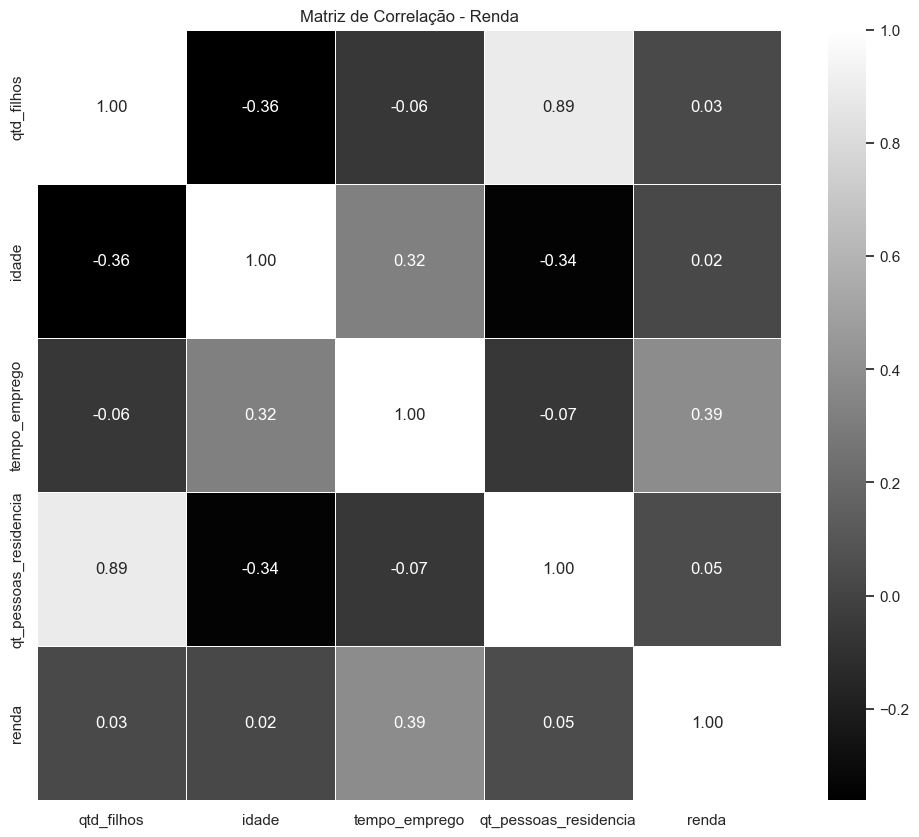

In [58]:
# Matriz de correlação
numeric_renda = renda.select_dtypes(include='number')
correlation_matrix = numeric_renda.corr()
sns.set(style="white")
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="gray", annot=True, fmt=".2f", linewidths=.5)
plt.title("Matriz de Correlação - Renda")
plt.show()

#### Pair e Cluster Plot

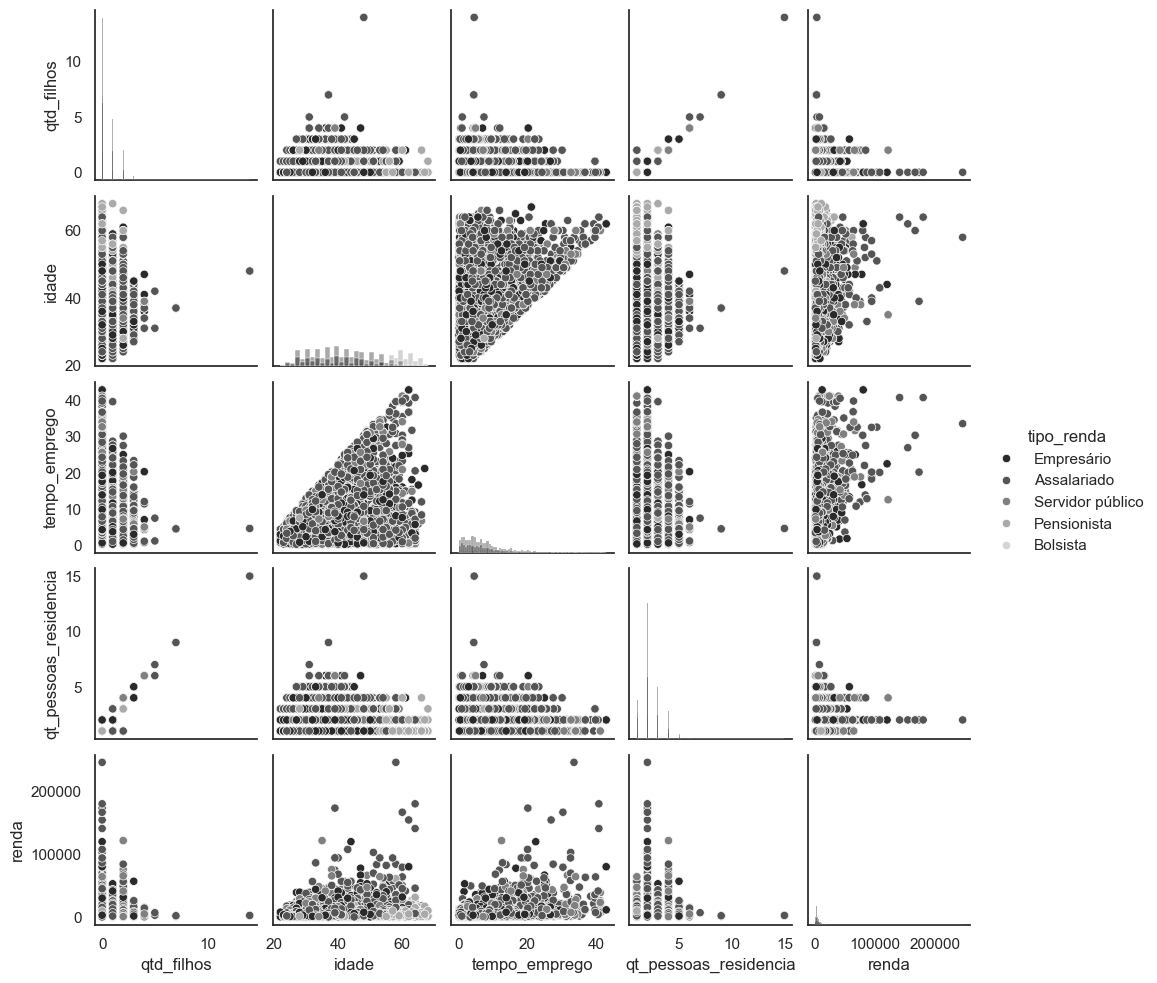

<Figure size 1000x1000 with 0 Axes>

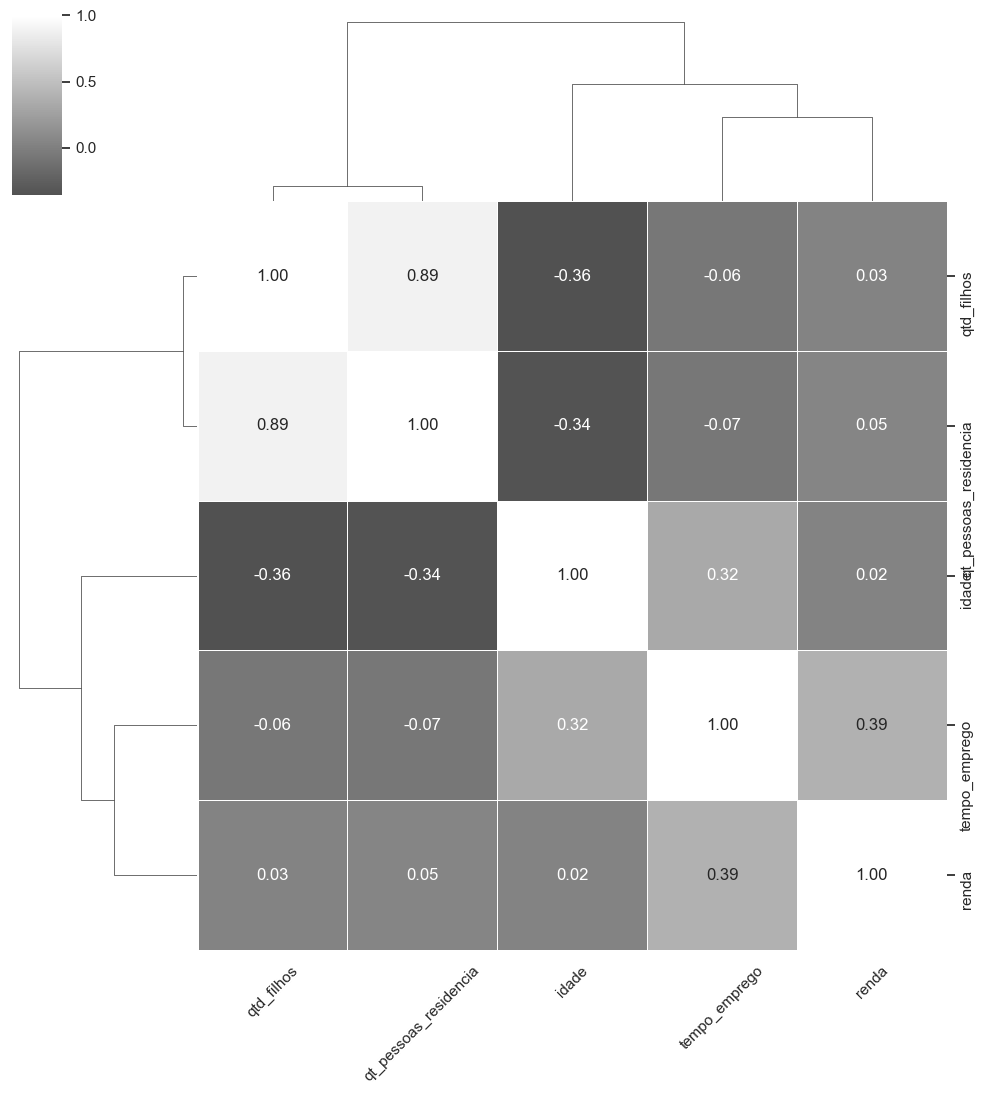

In [59]:
# Pairplot
sns.pairplot(data=renda, hue='tipo_renda', vars=['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda'], diag_kind='hist', height=2, palette="gray")

# Clustermap
plt.figure(figsize=(10, 10))
ax = sns.clustermap(data=renda.select_dtypes(include='number').corr(), center=0, cmap="gray", annot=True, fmt=".2f", linewidths=.5)
plt.setp(ax.ax_heatmap.get_xticklabels(), rotation=45)
plt.show()

## Scatter plot

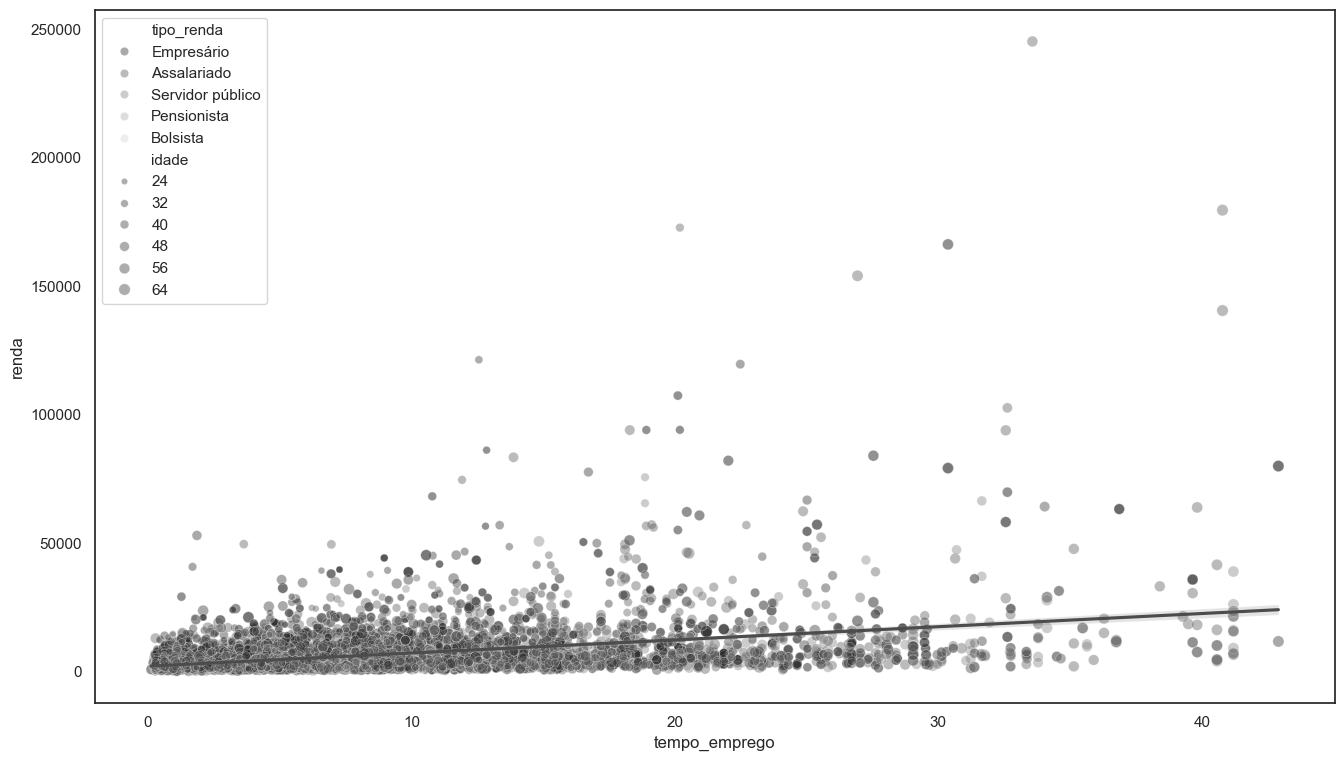

In [60]:
# Scatterplot
plt.figure(figsize=(16, 9))
sns.scatterplot(x='tempo_emprego', y='renda', hue='tipo_renda', size='idade', data=renda, alpha=0.4, palette="gray")
sns.regplot(x='tempo_emprego', y='renda', data=renda, scatter=False, color='.3')
plt.show()

### Análise das variáveis qualitativas

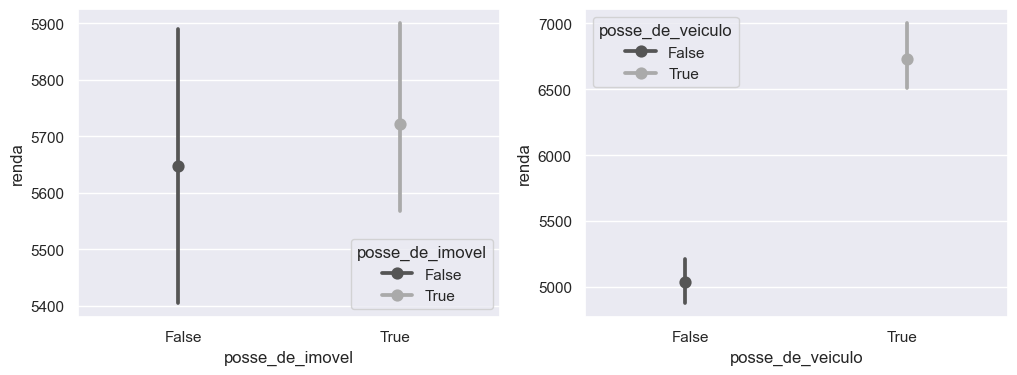

In [61]:
# Relevância variável veiculo e imovel
sns.set(rc={'figure.figsize': (12, 4)})
fig, axes = plt.subplots(1, 2)
sns.pointplot(x='posse_de_imovel', y='renda', data=renda, dodge=True, ax=axes[0], hue='posse_de_imovel', palette="gray")
sns.pointplot(x='posse_de_veiculo', y='renda', data=renda, dodge=True, ax=axes[1], hue='posse_de_veiculo', palette="gray")
plt.show()

### Análise das variáveis qualitativas ao longo do tempo

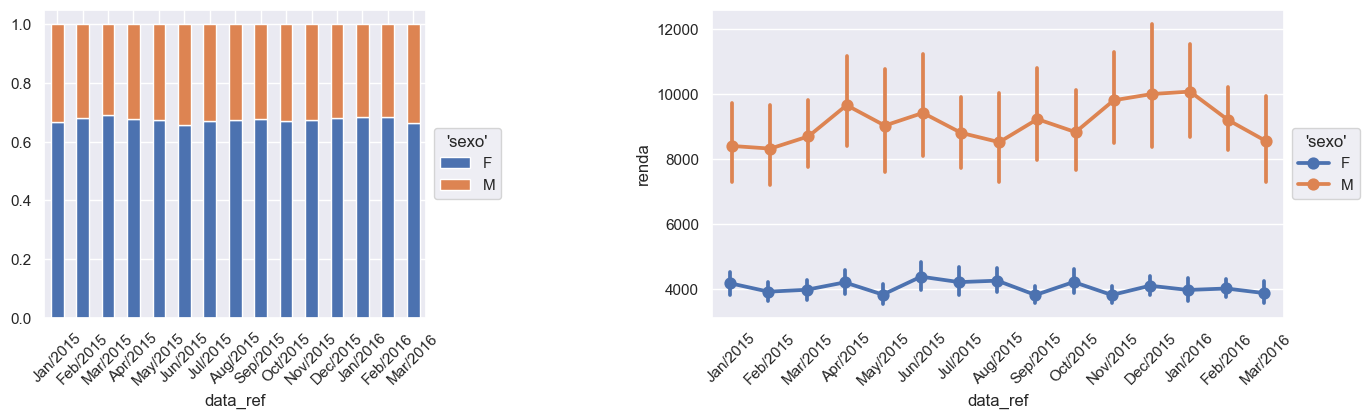

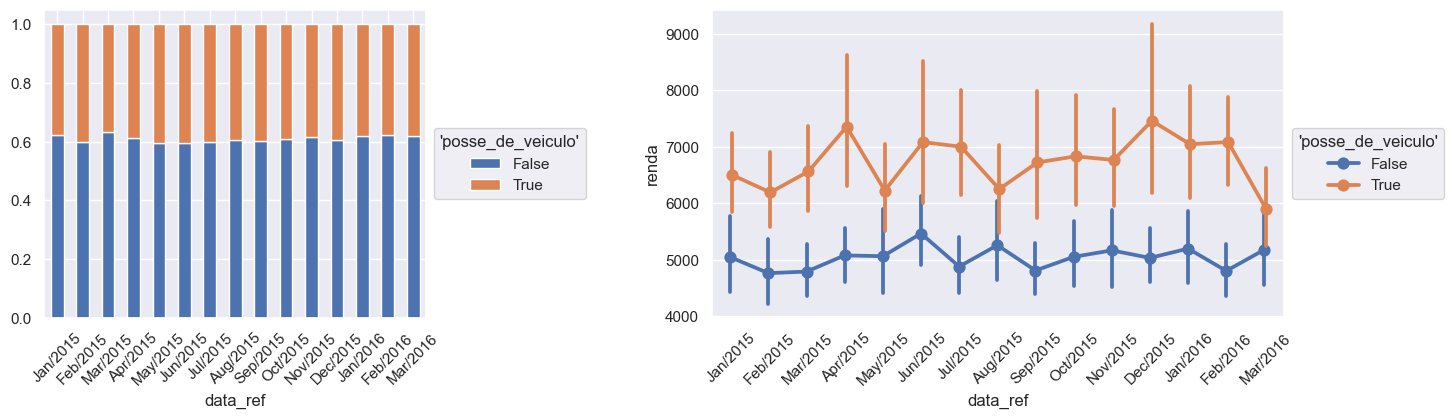

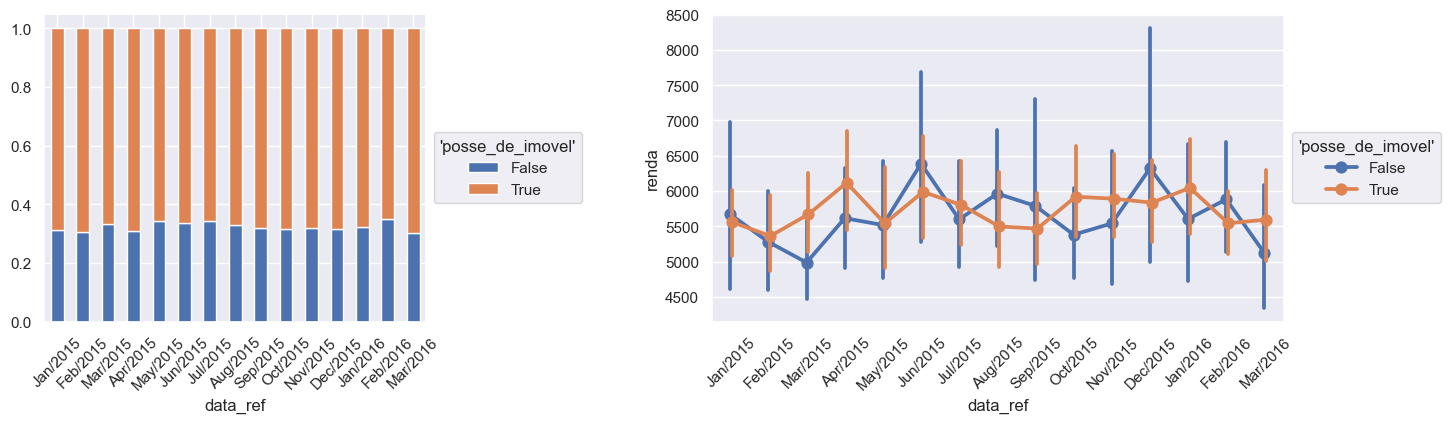

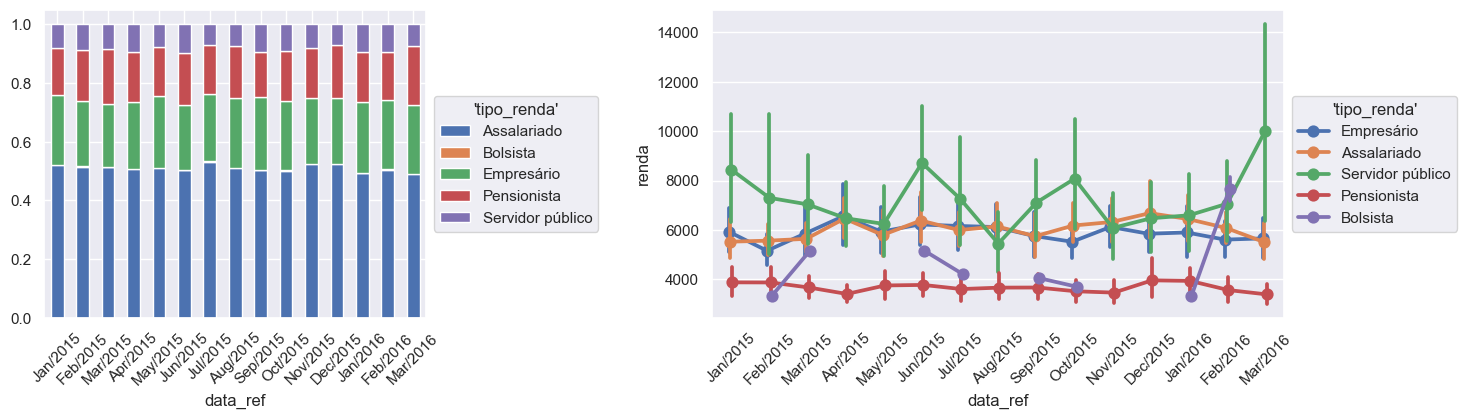

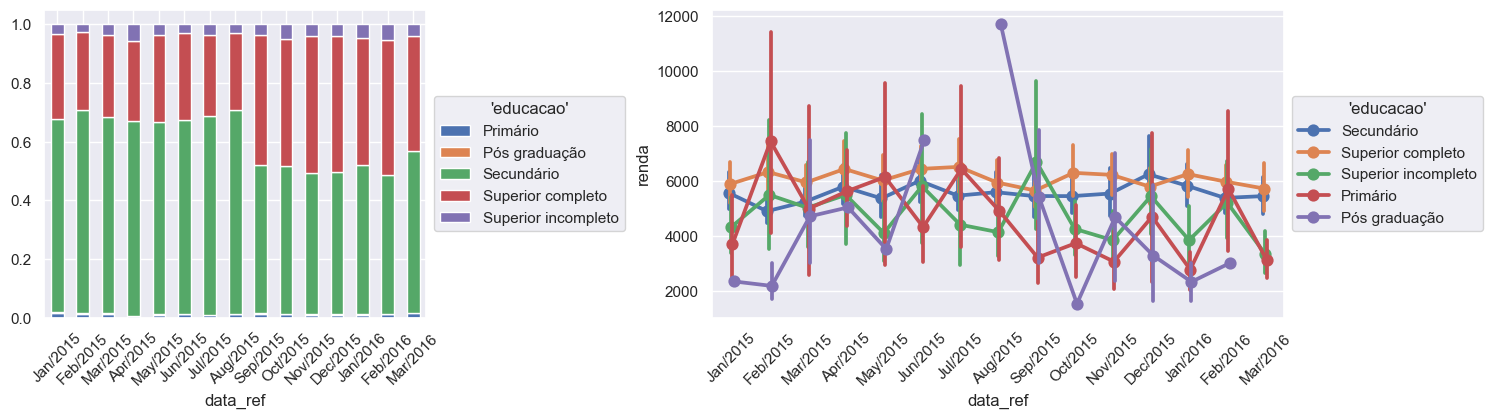

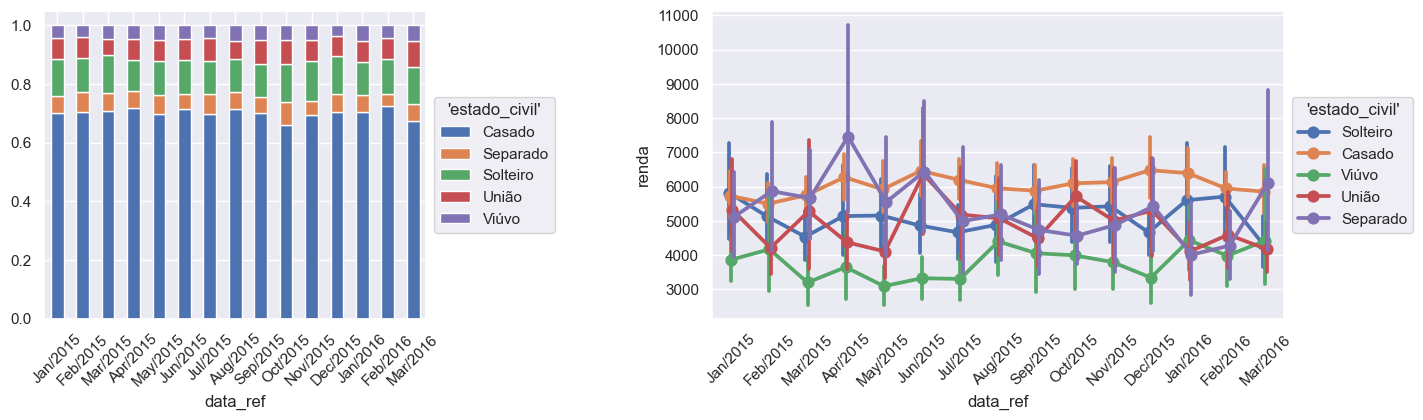

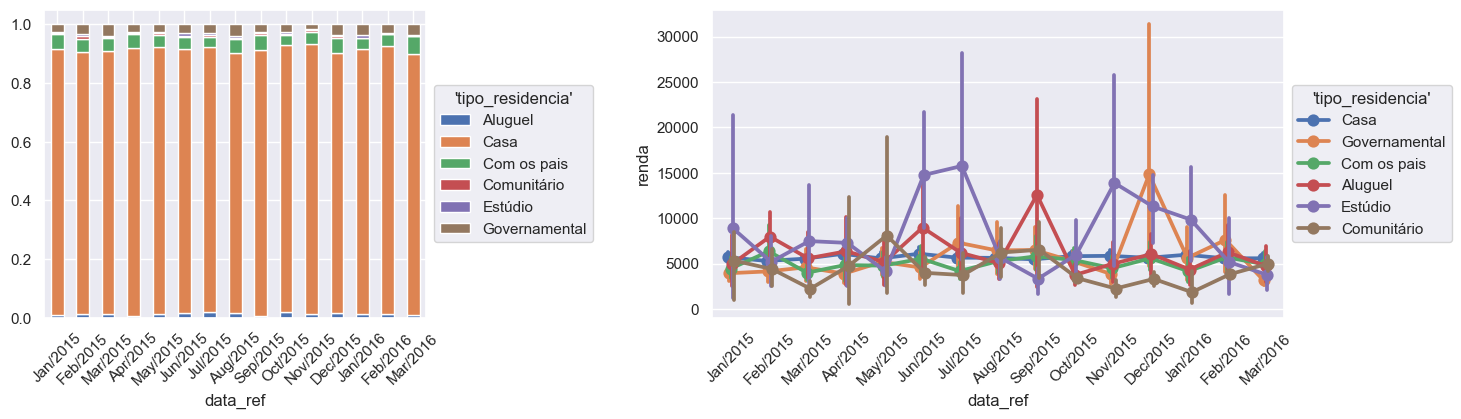

In [62]:
renda['data_ref'] = pd.to_datetime(renda['data_ref'])
qualitative_columns = renda.select_dtypes(include=['object', 'boolean']).columns

plt.rc('figure', figsize=(16, 4))

for col in qualitative_columns:
    fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1.5]})
    fig.subplots_adjust(wspace=.6)

    # Stacked bar plot
    renda_crosstab = pd.crosstab(index=renda['data_ref'], columns=renda[col], normalize='index')
    ax0 = renda_crosstab.plot.bar(stacked=True, ax=axes[0])
    tick_labels = renda['data_ref'].dt.strftime('%b/%Y').unique()
    ax0.set_xticklabels(labels=tick_labels, rotation=45)
    ax0.legend(bbox_to_anchor=(1, .5), loc=6, title=f"'{col}'")

    # Point plot for average income over time
    sns.pointplot(x='data_ref', y='renda', hue=col, data=renda, dodge=True, errorbar=('ci', 95), ax=axes[1])
    axes[1].set_xticks(list(range(len(tick_labels))))
    axes[1].set_xticklabels(labels=tick_labels, rotation=45)
    axes[1].legend(bbox_to_anchor=(1, .5), loc=6, title=f"'{col}'")

    plt.show()

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



In [63]:
# Limpeza
renda = renda.drop(columns='data_ref', errors='ignore').dropna()

### Conversão das variáveis categóricas em variáveis numéricas (dummies)

In [65]:
# Dummies
renda_dummies = pd.get_dummies(renda)
renda_dummies_info = renda_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12090 entries, 0 to 14592
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posse_de_veiculo               12090 non-null  bool   
 1   posse_de_imovel                12090 non-null  bool   
 2   qtd_filhos                     12090 non-null  int64  
 3   idade                          12090 non-null  int64  
 4   tempo_emprego                  12090 non-null  float64
 5   qt_pessoas_residencia          12090 non-null  float64
 6   renda                          12090 non-null  float64
 7   sexo_F                         12090 non-null  bool   
 8   sexo_M                         12090 non-null  bool   
 9   tipo_renda_Assalariado         12090 non-null  bool   
 10  tipo_renda_Bolsista            12090 non-null  bool   
 11  tipo_renda_Empresário          12090 non-null  bool   
 12  tipo_renda_Pensionista         12090 non-null  bool

In [67]:
# Correlação 
correlation_result = (renda_dummies.corr()['renda']
    .sort_values(ascending=False)
    .to_frame()
    .reset_index()
    .rename(columns={'index': 'var', 'renda': 'corr'})
    .style.bar(color=['darkred', 'darkgreen'], align=0))
correlation_result

## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


### Divisão da base em treino e teste


In [68]:
X = renda_dummies.drop(columns='renda')
y = renda_dummies['renda']
print(f'X shape: {X.shape}, y length: {len(y)}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f'Training set: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'Testing set: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X shape: (12090, 29), y length: 12090
Training set: X_train shape: (9067, 29), y_train shape: (9067,)
Testing set: X_test shape: (3023, 29), y_test shape: (3023,)


## Seleção de hiperparâmetros do modelo com for loop

In [69]:
# Selecionando Hyperparametros
hyperparameters = list(product(range(1, 21), range(1, 31)))
score = pd.DataFrame({
    'max_depth': [max_depth for max_depth, min_samples_leaf in hyperparameters],
    'min_samples_leaf': [min_samples_leaf for max_depth, min_samples_leaf in hyperparameters],
    'score': [(reg := DecisionTreeRegressor(random_state=42, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
               .fit(X_train, y_train)
               .score(X_test, y_test)) for max_depth, min_samples_leaf in hyperparameters]
}).sort_values(by='score', ascending=False)
score = score.sort_values(by='score', ascending=False)
print(score)

     max_depth  min_samples_leaf     score
213          8                 4  0.417122
543         19                 4  0.401091
243          9                 4  0.401005
393         14                 4  0.400246
245          9                 6  0.399395
..         ...               ...       ...
11           1                12  0.056241
12           1                13  0.056241
13           1                14  0.056241
8            1                 9  0.056241
0            1                 1  0.056241

[600 rows x 3 columns]


### Rodando o modelo


In [70]:
reg_tree = DecisionTreeRegressor(random_state=42, max_depth=8, min_samples_leaf=4)
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=4, random_state=42)

Visualização gráfica da árvore com plot_tree

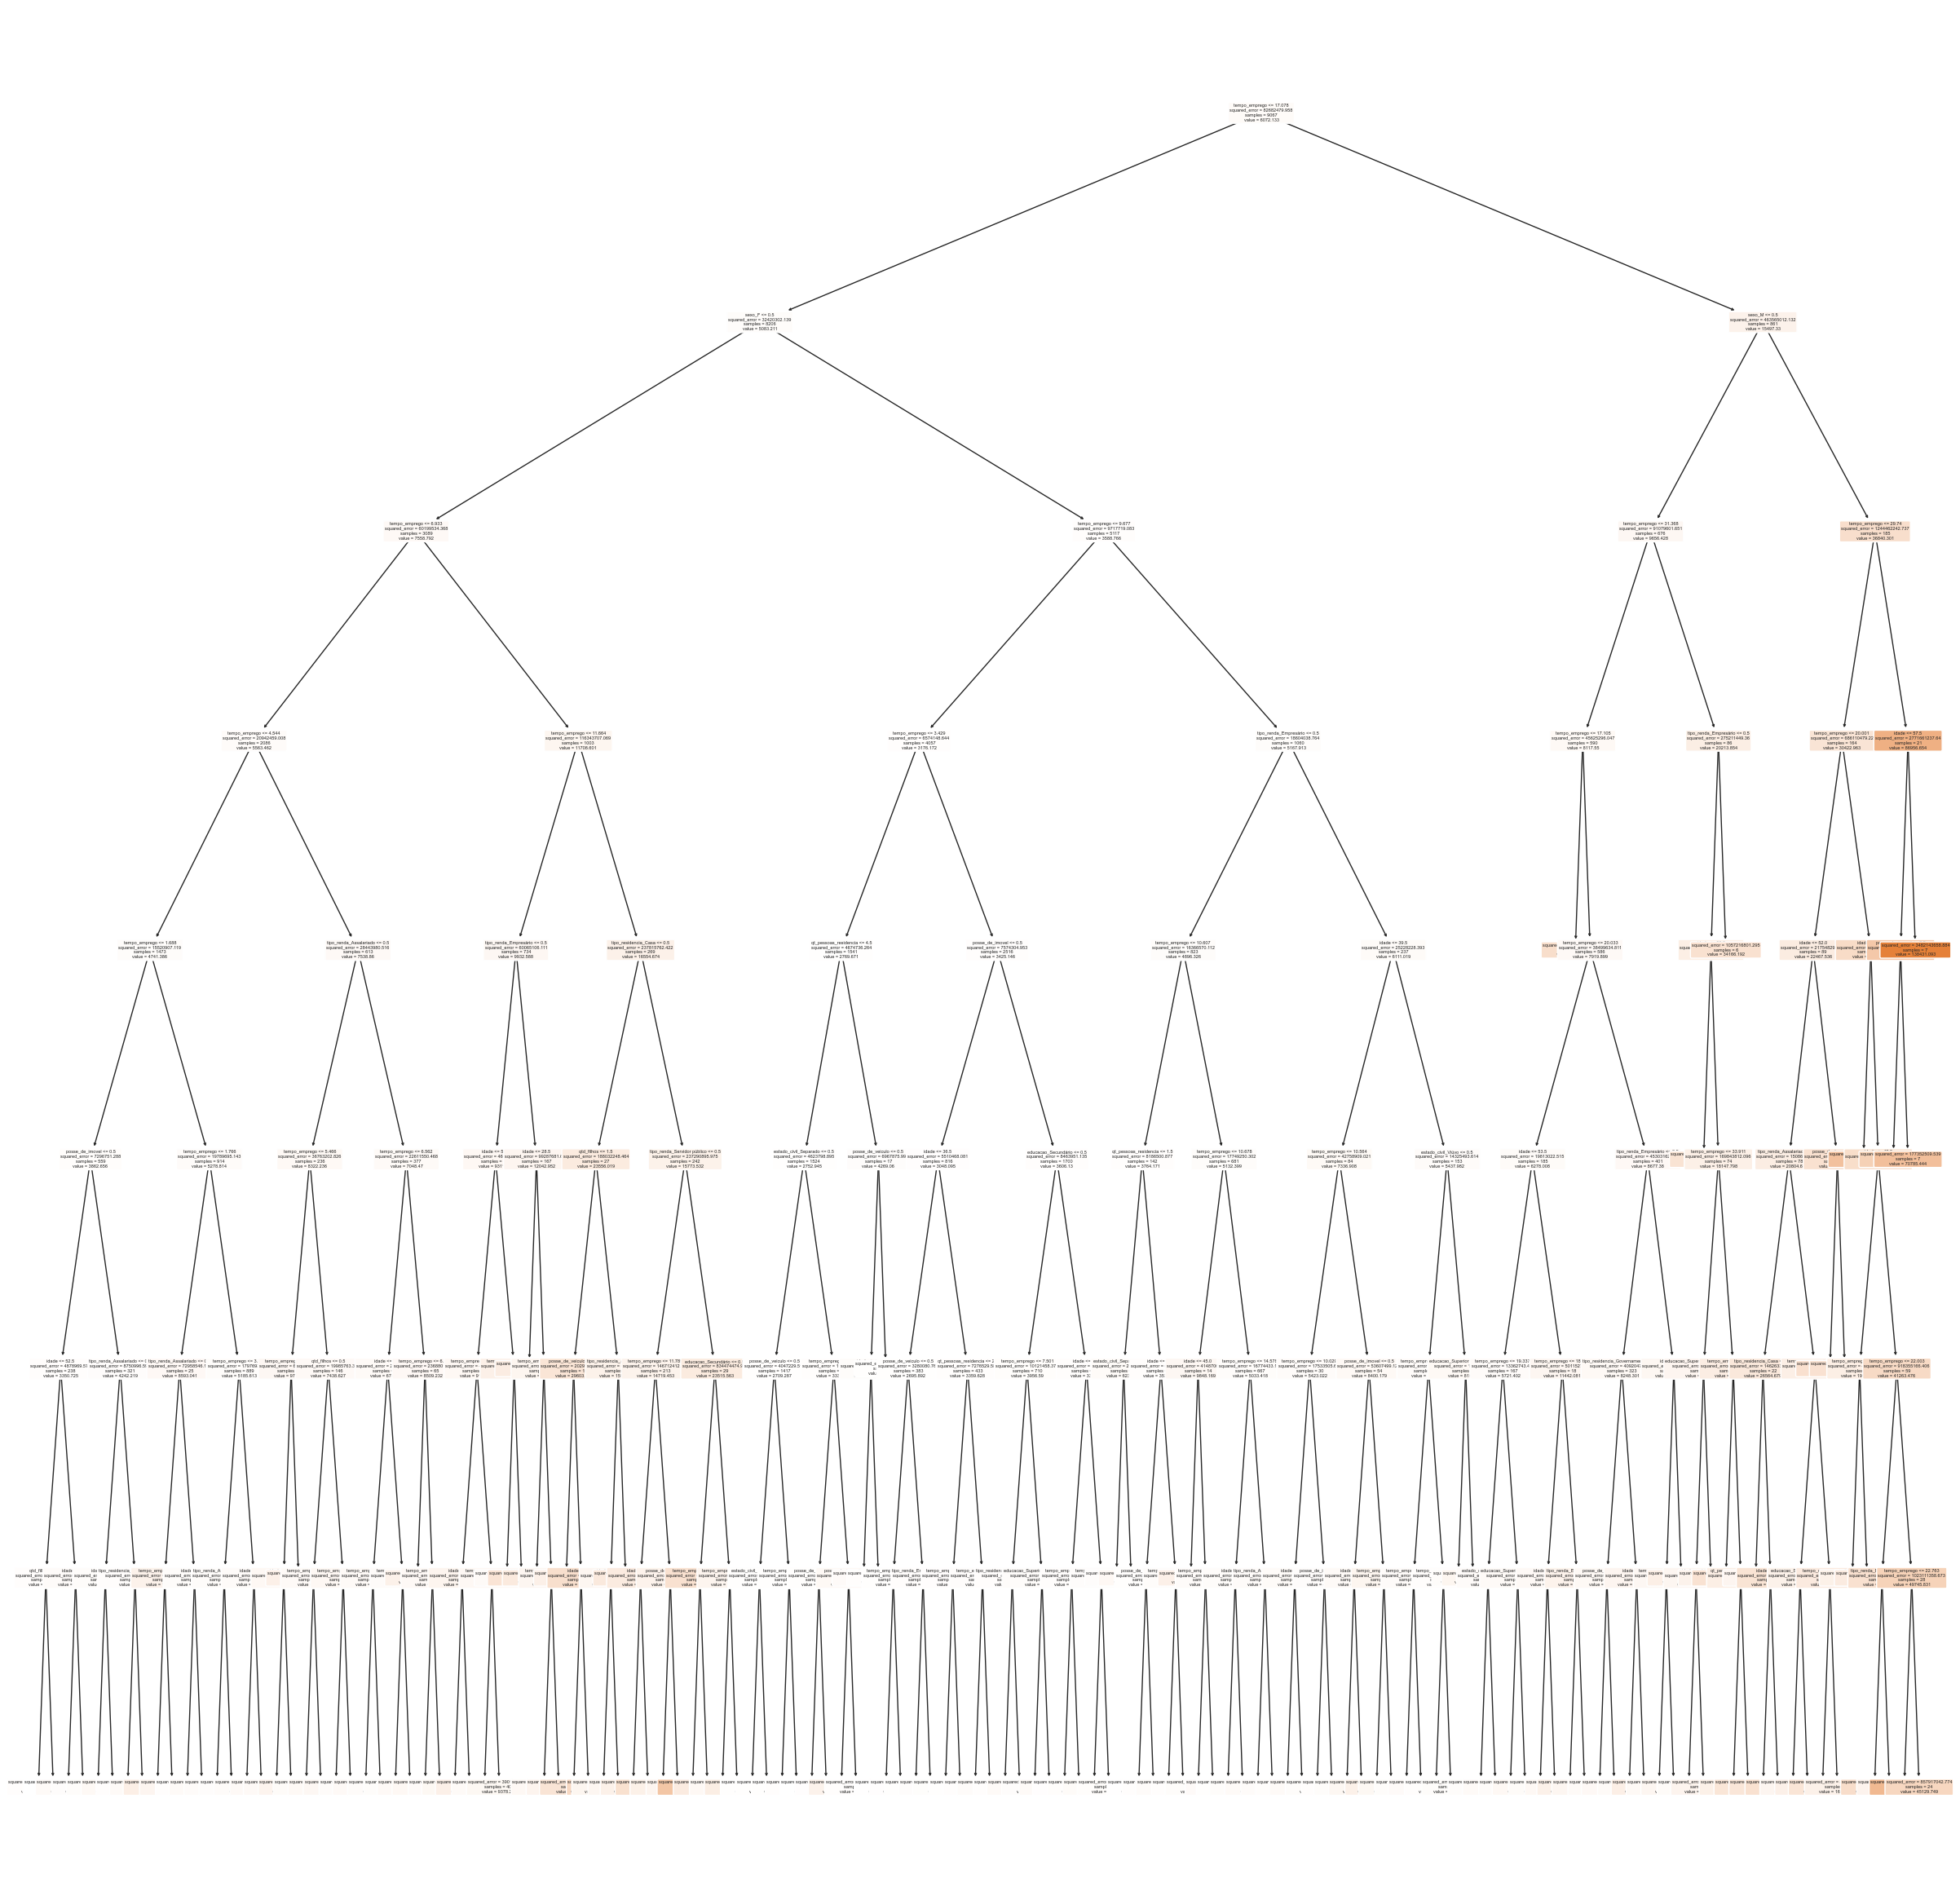

In [71]:
# Visualização da Árvore
plt.rc('figure', figsize=(30, 30))
plt.figure()
plot_tree(reg_tree, feature_names=list(X_train.columns) + list(X.columns), filled=True, rounded=True, fontsize=4)
plt.show()

Visualização impressa da árvore

In [74]:
# Árvore Impressa
print(tree.export_text(reg_tree))

|--- feature_4 <= 17.08
|   |--- feature_6 <= 0.50
|   |   |--- feature_4 <= 6.93
|   |   |   |--- feature_4 <= 4.54
|   |   |   |   |--- feature_4 <= 1.69
|   |   |   |   |   |--- feature_1 <= 0.50
|   |   |   |   |   |   |--- feature_3 <= 52.50
|   |   |   |   |   |   |   |--- feature_2 <= 2.50
|   |   |   |   |   |   |   |   |--- value: [3237.54]
|   |   |   |   |   |   |   |--- feature_2 >  2.50
|   |   |   |   |   |   |   |   |--- value: [1415.27]
|   |   |   |   |   |   |--- feature_3 >  52.50
|   |   |   |   |   |   |   |--- feature_3 <= 56.00
|   |   |   |   |   |   |   |   |--- value: [6817.46]
|   |   |   |   |   |   |   |--- feature_3 >  56.00
|   |   |   |   |   |   |   |   |--- value: [4458.54]
|   |   |   |   |   |--- feature_1 >  0.50
|   |   |   |   |   |   |--- feature_8 <= 0.50
|   |   |   |   |   |   |   |--- feature_3 <= 54.50
|   |   |   |   |   |   |   |   |--- value: [4821.44]
|   |   |   |   |   |   |   |--- feature_3 >  54.50
|   |   |   |   |   |   |   |   |--

## Etapa 5 Crisp-DM: Avaliação dos resultados


In [77]:
# Avaliação
r2_train = reg_tree.score(X_train, y_train)
r2_test = reg_tree.score(X_test, y_test)
template = f'O coeficiente de determinação (𝑅2) da árvore com profundidade = {reg_tree.get_depth()} para a base de {{}} é: {{:.2f}}'
print(template.format('treino', r2_train).replace(".", ","))
print(template.format('teste', r2_test).replace(".", ","), '\n')

O coeficiente de determinação (𝑅2) da árvore com profundidade = 8 para a base de treino é: 0,60
O coeficiente de determinação (𝑅2) da árvore com profundidade = 8 para a base de teste é: 0,42 



## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.

In [80]:
# Renda
entrada_data = {
    'sexo': 'M',
    'posse_de_veiculo': False,
    'posse_de_imovel': True,
    'qtd_filhos': 1,
    'tipo_renda': 'Assalariado',
    'educacao': 'Superior completo',
    'estado_civil': 'Solteiro',
    'tipo_residencia': 'Casa',
    'idade': 34,
    'tempo_emprego': None,
    'qt_pessoas_residencia': 1}
entrada = pd.DataFrame([entrada_data])
entrada = pd.get_dummies(entrada).reindex(columns=X.columns, fill_value=0)
entrada = pd.concat([X, entrada], sort=False).fillna(0).tail(1)
predicted_renda = np.round(reg_tree.predict(entrada), 2)
if isinstance(predicted_renda, np.ndarray):
    predicted_renda = predicted_renda[0]
print(f"Renda estimada: R${predicted_renda:.2f}".replace('.', ','))

Renda estimada: R$3671,41
